# Remake Figure S7: Analyze Co-expression of Dimerizing Transcription Factors

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20231019

This brief notebook will analyze the co-expression of bZIP and nuclear receptor (NR) transcription factors from both mouse and human datasets.

**Mouse dataset**

Integrated mouse transcriptomics dataset from the follow preprint:\
https://doi.org/10.1101/2022.08.21.504714

The expression values are scaled to be between 0 and 1 where 1 corresponds to the 99th percentile for that gene.

**Human dataset**

Human Protein Atlas version 23.0 ["RNA single cell type data" dataset](https://www.proteinatlas.org/about/download)


In [1]:
import importlib
import itertools
import math
import numpy as np
import os
import pandas as pd
import pathlib
import scipy.stats
import sys
import time

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import seaborn as sns

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
import dimer_network_utilities
from dimer_network_utilities import *

In [ ]:
# Define directory of the archived data folder parresgold_2023_dimer_networks_data
load_dir = str(pathlib.Path('E:\\','parresgold_2023_dimer_networks','parresgold_2023_dimer_networks_data'))

In [4]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [5]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [6]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Mouse Dataset

In [7]:
expression_threshold_mouse = 0.2 # All expression was normalized 0-1

### bZIP Proteins

Candidates identified from here:\
https://www.uniprot.org/uniprotkb?dir=ascend&query=%28family%3A%22bZIP+family%22%29&sort=id&facets=model_organism%3A10090

In [8]:
bZIP_mouse_expression_matrix = pd.read_csv(pathlib.Path(load_dir,'transcription_factor_coexpression','bZIP_mouse_expression_matrix.csv'),header=0).drop(columns=['Unnamed: 0'])
bZIP_proteins_mouse = bZIP_mouse_expression_matrix.columns[:-5]
print("{} Mouse bZIPs".format(len(bZIP_proteins_mouse)))
bZIP_mouse_expression_matrix.head()

46 Mouse bZIPs


,Atf1,Atf2,Atf3,Atf4,Atf5,Atf6,Atf6b,Atf7,Bach1,Bach2,...,Nfe2l2,Nfe2l3,Nfil3,Tef,Xbp1,Tissue,age,dataset,cell_ontology_class,Cell_class
0,0.512379,0.427577,0.003886,0.296247,0.067371,0.051247,0.328276,0.116136,0.155770,0.043283,...,0.148914,0.031139,0.032559,0.098980,0.060708,epiblast,E6.5,E6.5_8.5_Chan,epiblast,Epiblast
1,0.479221,0.262774,0.002705,0.203223,0.055729,0.022225,0.179088,0.060866,0.067978,0.000000,...,0.086254,0.000000,0.048496,0.024738,0.026379,ectoderm,E6.5,E6.5_8.5_Chan,ectoderm early 2,Ectoderm
2,0.564973,0.447058,0.005379,0.296125,0.037810,0.084751,0.318778,0.122336,0.162716,0.013351,...,0.152984,0.102429,0.035186,0.125260,0.035642,epiblast,E6.5,E6.5_8.5_Chan,epiblast,Epiblast
3,0.617650,0.406024,0.002747,0.274501,0.056137,0.073334,0.356172,0.074260,0.170188,0.000000,...,0.185255,0.137319,0.026574,0.093088,0.043788,epiblast,E6.5,E6.5_8.5_Chan,epiblast,Epiblast
4,0.424298,0.370696,0.001758,0.295760,0.036002,0.110598,0.322413,0.206830,0.125046,0.005938,...,0.299145,0.030971,0.027905,0.091521,0.070776,xecto,E6.5,E6.5_8.5_Chan,extraembryonic ectoderm 1,Ex_ectoderm


In [9]:
bzip_columns = bZIP_mouse_expression_matrix.columns[:len(bZIP_proteins_mouse)]
cell_info_columns = bZIP_mouse_expression_matrix.columns[len(bZIP_proteins_mouse):]

num_coexpressed_bZIPs_mouse = bZIP_mouse_expression_matrix.loc[:,cell_info_columns]

# Count number of coexpressed proteins
num_coexpressed_bZIPs_mouse['coexpressed'] = bZIP_mouse_expression_matrix.loc[:,bzip_columns].applymap(lambda x: x>expression_threshold_mouse).sum(axis=1)

# Aggregate by cell type
num_coexpressed_bZIPs_mouse = num_coexpressed_bZIPs_mouse.groupby(['cell_ontology_class'],as_index=False)['coexpressed'].agg('max').reset_index(drop=True)

num_coexpressed_bZIPs_mouse.head()

,cell_ontology_class,coexpressed
0,Allantois,14
1,Anterior Primitive Streak,9
2,B cell,27
3,Blood progenitors 2,10
4,CD4-positive alpha-beta T cell,13


### Nuclear Receptors

Candidates identified from here:\
https://www.uniprot.org/uniprotkb?dir=ascend&query=%28family%3A%22nuclear+hormone+receptor+family%22%29&sort=gene&facets=model_organism%3A10090

In [25]:
NR_mouse_expression_matrix = pd.read_csv(pathlib.Path(load_dir,'transcription_factor_coexpression','NR_mouse_expression_matrix.csv'),header=0).drop(columns=['Unnamed: 0'])
NR_proteins_mouse = NR_mouse_expression_matrix.columns[:-5]
print("{} Mouse Nuclear Receptors".format(len(NR_proteins_mouse)))
NR_mouse_expression_matrix.head()

27 Mouse Nuclear Receptors


,Ar,Esrra,Esrrb,Nr1h2,Nr1h3,Nr1d1,Nr1d2,Nr2c2,Nr2f2,Nr2c1,...,Rorb,Rxra,Rxrb,Rxrg,Thra,Tissue,age,dataset,cell_ontology_class,Cell_class
0,0.066010,0.046363,0.038600,0.345857,0.012572,0.029685,0.070422,0.392074,0.000633,0.291243,...,0.000000,0.066872,0.443578,0.257678,0.144371,epiblast,E6.5,E6.5_8.5_Chan,epiblast,Epiblast
1,0.000000,0.025488,0.022570,0.278404,0.013579,0.018302,0.024359,0.081686,0.000000,0.081163,...,0.000000,0.049258,0.235991,0.118383,0.046273,ectoderm,E6.5,E6.5_8.5_Chan,ectoderm early 2,Ectoderm
2,0.049918,0.076780,0.041658,0.372976,0.007340,0.037962,0.081308,0.505464,0.002726,0.258916,...,0.119419,0.080455,0.456484,0.056483,0.070931,epiblast,E6.5,E6.5_8.5_Chan,epiblast,Epiblast
3,0.074942,0.036735,0.026331,0.422760,0.012012,0.036857,0.051242,0.333237,0.001281,0.347970,...,0.071116,0.077379,0.386593,0.133879,0.127363,epiblast,E6.5,E6.5_8.5_Chan,epiblast,Epiblast
4,0.000000,0.172042,1.000000,0.327846,0.010838,0.021508,0.032842,0.183491,0.012412,0.133481,...,0.000000,0.070295,0.532889,0.000000,0.021712,xecto,E6.5,E6.5_8.5_Chan,extraembryonic ectoderm 1,Ex_ectoderm


In [26]:
bzip_columns = NR_mouse_expression_matrix.columns[:len(NR_proteins_mouse)]
cell_info_columns = NR_mouse_expression_matrix.columns[len(NR_proteins_mouse):]

num_coexpressed_NRs_mouse = NR_mouse_expression_matrix.loc[:,cell_info_columns]

# Count number of coexpressed proteins
num_coexpressed_NRs_mouse['coexpressed'] = NR_mouse_expression_matrix.loc[:,bzip_columns].applymap(lambda x: x>expression_threshold_mouse).sum(axis=1)

# Aggregate by cell type
num_coexpressed_NRs_mouse = num_coexpressed_NRs_mouse.groupby(['cell_ontology_class'],as_index=False)['coexpressed'].agg('max').reset_index(drop=True)

num_coexpressed_NRs_mouse.head()

,cell_ontology_class,coexpressed
0,Allantois,6
1,Anterior Primitive Streak,6
2,B cell,12
3,Blood progenitors 2,3
4,CD4-positive alpha-beta T cell,7


## Human Dataset

In [12]:
expression_threshold_human = 5 # This seems to be the amount for "expressed" in nTPM

### bZIP Proteins

Candidates identified from here:\
https://www.uniprot.org/uniprotkb?dir=ascend&query=%28family%3A%22bZIP+family%22%29&sort=id&facets=model_organism%3A9606

In [13]:
bZIP_human_expression_matrix = pd.read_csv(pathlib.Path(load_dir,'transcription_factor_coexpression','bZIP_human_expression_matrix.csv'))
bZIP_proteins_human = list(bZIP_human_expression_matrix['Gene name'].unique())
print("{} Human bZIPs".format(len(bZIP_proteins_human)))
bZIP_human_expression_matrix.head()

56 Human bZIPs


,Gene,Gene name,Cell type,nTPM
0,ENSG00000050344,NFE2L3,Adipocytes,14.8
1,ENSG00000050344,NFE2L3,Alveolar cells type 1,3.3
2,ENSG00000050344,NFE2L3,Alveolar cells type 2,1.5
3,ENSG00000050344,NFE2L3,Astrocytes,3.8
4,ENSG00000050344,NFE2L3,B-cells,4.0


In [14]:
bZIP_human_expression_matrix['coexpressed'] = bZIP_human_expression_matrix['nTPM']>expression_threshold_human
num_coexpressed_bZIPs_human = bZIP_human_expression_matrix.groupby(by=['Cell type'],as_index=False)['coexpressed'].agg('sum')
num_coexpressed_bZIPs_human.head()

,Cell type,coexpressed
0,Adipocytes,46
1,Alveolar cells type 1,39
2,Alveolar cells type 2,44
3,Astrocytes,31
4,B-cells,42


### Nuclear Receptors

Candidates identified from here:\
https://www.uniprot.org/uniprotkb?dir=ascend&query=%28family%3A%22nuclear+hormone+receptor+family%22%29&sort=gene&facets=model_organism%3A9606

In [27]:
NR_human_expression_matrix = pd.read_csv(pathlib.Path(load_dir,'transcription_factor_coexpression','NR_human_expression_matrix.csv'))
NR_proteins_human = list(NR_human_expression_matrix['Gene name'].unique())
print("{} Human Nuclear Receptors".format(len(NR_proteins_human)))
NR_human_expression_matrix.head()

48 Human Nuclear Receptors


,Gene,Gene name,Cell type,nTPM
0,ENSG00000012504,NR1H4,Adipocytes,0.0
1,ENSG00000012504,NR1H4,Alveolar cells type 1,0.0
2,ENSG00000012504,NR1H4,Alveolar cells type 2,0.0
3,ENSG00000012504,NR1H4,Astrocytes,0.3
4,ENSG00000012504,NR1H4,B-cells,2.4


In [28]:
NR_human_expression_matrix['coexpressed'] = NR_human_expression_matrix['nTPM']>expression_threshold_human
num_coexpressed_NRs_human = NR_human_expression_matrix.groupby(by=['Cell type'],as_index=False)['coexpressed'].agg('sum')
num_coexpressed_NRs_human.head()

,Cell type,coexpressed
0,Adipocytes,25
1,Alveolar cells type 1,21
2,Alveolar cells type 2,29
3,Astrocytes,28
4,B-cells,20


## Plot

### bZIPs

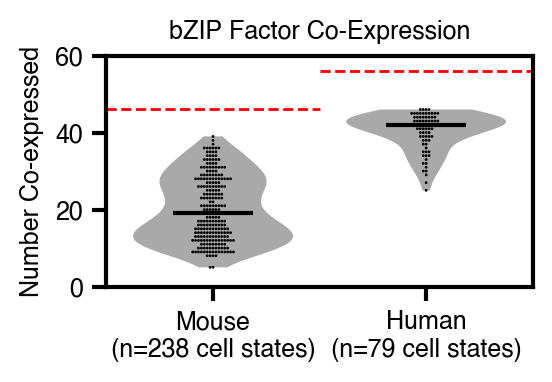

In [31]:
save = True
s = 1
alpha=1
plotpoints=True
subsample = 250

organisms = ['Mouse','Human']

datasets = [num_coexpressed_bZIPs_mouse['coexpressed'].tolist(),\
            num_coexpressed_bZIPs_human['coexpressed'].tolist()]

rng = np.random.default_rng()

fig, ax = plt.subplots(figsize=(2.75,1.5))

for organism_i, organism in enumerate(organisms):
    # Make violin plot
    parts = ax.violinplot(positions = [organism_i],\
                dataset = [datasets[organism_i]],\
                showmedians=True,\
                showextrema=False,\
                showmeans=False,\
                widths=0.75,
    )
    for face in parts['bodies']:
        face.set_facecolor('darkgray')
        face.set_alpha(1)
    parts['cmedians'].set_color('r')
    parts['cmedians'].set_linewidth(2)
    if plotpoints:
        points = datasets[organism_i]
        if type(subsample)==int and len(points)>subsample:
            points = rng.choice(points,size=subsample,replace=False)
        subsample_df = pd.DataFrame({'x':np.full((len(points),),organism_i),'y':points})
        sns.swarmplot(data=subsample_df,x='x',y='y',orient='v',native_scale=True,\
            color='k',size=s,alpha=alpha,edgecolor='none',ax=ax)

_ = ax.set_xlabel('')

# Plot lines for theoretical max
ax.hlines(y=[len(bZIP_proteins_mouse),len(bZIP_proteins_human)],xmin=[-0.5,0.5],xmax=[0.5,1.5],linestyle='--',color='k',linewidth=1)

_ = ax.set_ylabel('Number Co-expressed',fontsize=9)
_ = ax.set_title('bZIP Factor Co-Expression',fontsize=9)

_ = ax.set_ylim([0,60])
_ = ax.set_xlim([-0.5,1.5])
_ = ax.set_xticks(list(range(len(organisms))))
_ = ax.set_xticklabels(["{}\n(n={} cell states)".format(organism,len(datasets[organism_i])) for organism_i,organism in enumerate(organisms)])

# Customize spines
set_spine_linewidth(ax,1.5)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks

fig.set_dpi(200)

if save:
    filename = f'FigS7A_bZIP_coexpression'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### NRs

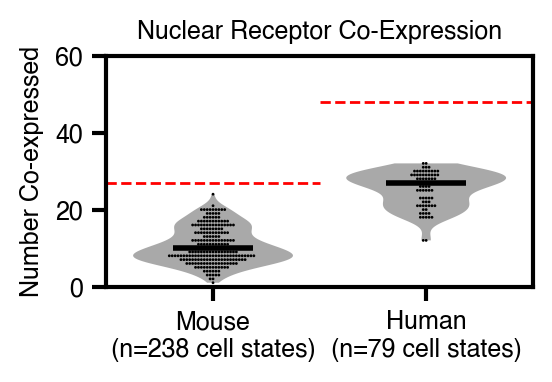

In [30]:
save = True
s = 1
alpha=1
plotpoints=True

organisms = ['Mouse','Human']

datasets = [num_coexpressed_NRs_mouse['coexpressed'].tolist(),\
            num_coexpressed_NRs_human['coexpressed'].tolist()]

rng = np.random.default_rng()

fig, ax = plt.subplots(figsize=(2.75,1.5))

for organism_i, organism in enumerate(organisms):
    # Make violin plot
    parts = ax.violinplot(positions = [organism_i],\
                dataset = [datasets[organism_i]],\
                showmedians=True,\
                showextrema=False,\
                showmeans=False,\
                widths=0.75,
    )
    for face in parts['bodies']:
        face.set_facecolor('darkgray')
        face.set_alpha(1)
    parts['cmedians'].set_color('r')
    parts['cmedians'].set_linewidth(2)
    if plotpoints:
        points = datasets[organism_i]
        if type(subsample)==int and len(points)>subsample:
            points = rng.choice(points,size=subsample,replace=False)
        subsample_df = pd.DataFrame({'x':np.full((len(points),),organism_i),'y':points})
        sns.swarmplot(data=subsample_df,x='x',y='y',orient='v',native_scale=True,\
            color='k',size=s,alpha=alpha,edgecolor='none',ax=ax)

_ = ax.set_xlabel('')

# Plot lines for theoretical max
ax.hlines(y=[len(NR_proteins_mouse),len(NR_proteins_human)],xmin=[-0.5,0.5],xmax=[0.5,1.5],linestyle='--',color='k',linewidth=1)

_ = ax.set_ylabel('Number Co-expressed',fontsize=9)
_ = ax.set_title('Nuclear Receptor Co-Expression',fontsize=9)

_ = ax.set_xlim([-0.5,1.5])
_ = ax.set_xticks(list(range(len(organisms))))
_ = ax.set_xticklabels(["{}\n(n={} cell states)".format(organism,len(datasets[organism_i])) for organism_i,organism in enumerate(organisms)])

_ = ax.set_ylim([0,60])

# Customize spines
set_spine_linewidth(ax,1.5)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1.5)  # Length and linewidth of major ticks

fig.set_dpi(200)

if save:
    filename = f'FigS7B_NR_coexpression'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

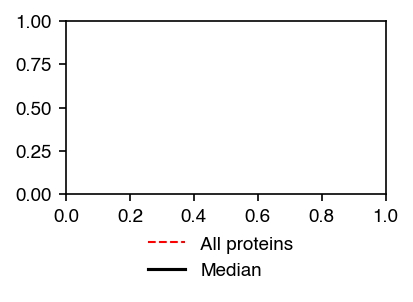

In [32]:
save = True

fig, ax = plt.subplots(figsize=(2.75,1.5))

# Make legend
patches={}
patches['red'] = mlines.Line2D([], [], color='k',ls='--',lw=1,label='All proteins')
patches['black'] = mlines.Line2D([], [], color='r',ls='-',lw=2,label='Median')

leg = fig.legend(bbox_to_anchor=(0.5, 0), loc='upper center',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    filename = f'FigS7legend'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')